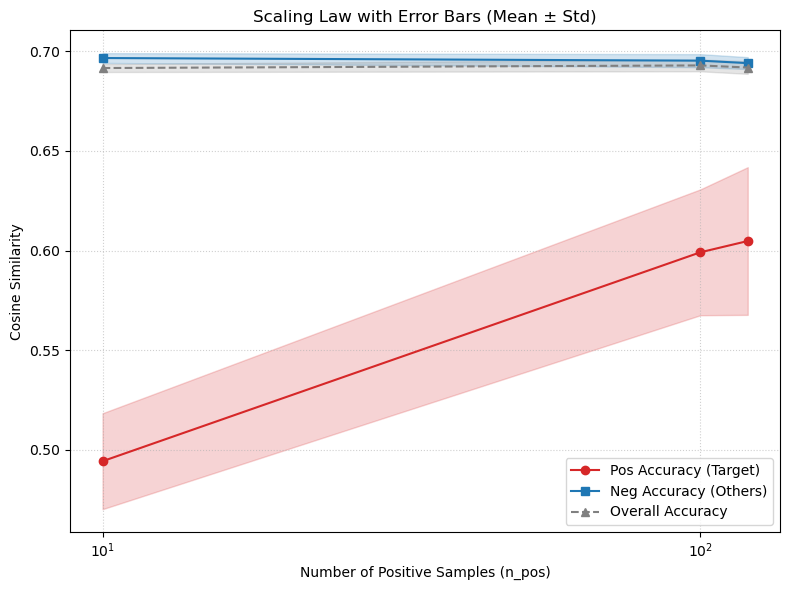

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

FLAG_COLUMN = "has_F"
TRAIN_MODE = "vanilla"  # "vanilla" or "class_balanced_loss"
VAL_METRIC = "val_loss"  # {"val_loss", "val_pos_loss"}

# 1. データの読み込み
df = pd.read_csv(f"output/csv/{FLAG_COLUMN}-{TRAIN_MODE}-esmetric={VAL_METRIC}-ae-v2.csv") 
# ※ここでは提示されたデータ形式と同じ構造を持つDataFrameがあると仮定します

# 2. 集計 (seedごとの平均と標準偏差を算出)
grouped = df.groupby("n_pos_req").agg({
    "pos_acc": ["mean", "std"],
    "neg_acc": ["mean", "std"],
    "overall_acc": ["mean", "std"]
}).reset_index()

# カラム名の整理 (pos_acc_mean, pos_acc_std ... という名前にする)
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]

# 3. プロット
plt.figure(figsize=(8, 6))

x = grouped["n_pos_req"]

# --- Pos Accuracy (赤色) ---
mean = grouped["pos_acc_mean"]
std = grouped["pos_acc_std"]
plt.plot(x, mean, marker='o', color='tab:red', label='Pos Accuracy (Target)')
# ★ここで fill_between を使用
plt.fill_between(x, mean - std, mean + std, color='tab:red', alpha=0.2)

# --- Neg Accuracy (青色) ---
mean = grouped["neg_acc_mean"]
std = grouped["neg_acc_std"]
plt.plot(x, mean, marker='s', color='tab:blue', label='Neg Accuracy (Others)')
plt.fill_between(x, mean - std, mean + std, color='tab:blue', alpha=0.2)

# --- Overall Accuracy (灰色) ---
mean = grouped["overall_acc_mean"]
std = grouped["overall_acc_std"]
plt.plot(x, mean, marker='^', linestyle='--', color='gray', label='Overall Accuracy')
plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2)

# 装飾
plt.xlabel('Number of Positive Samples (n_pos)')
plt.ylabel('Cosine Similarity')
plt.title('Scaling Law with Error Bars (Mean ± Std)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xscale('symlog', linthresh=1)
# plt.ylim(0.41, 0.77)
plt.legend()

plt.tight_layout()
# plt.savefig(f"tmp/{FLAG_COLUMN}-{TRAIN_MODE}-esmetric={VAL_METRIC}-ae.png", dpi=300)
plt.show()

   n_train  n_val  n_test  seed   pos_acc   neg_acc  overall_acc  best_epoch
0      500    500    1000     0  0.456591  0.526120     0.524034           3
1      500    500    1000     1  0.455325  0.564581     0.562505          84
2      500    500    1000     2  0.462707  0.518224     0.516558           3
3      500    500    1000     3  0.331396  0.536864     0.532550           3
4      500    500    1000     4  0.461569  0.534353     0.532678           3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   n_train      25 non-null     int64  
 1   n_val        25 non-null     int64  
 2   n_test       25 non-null     int64  
 3   seed         25 non-null     int64  
 4   pos_acc      25 non-null     float64
 5   neg_acc      25 non-null     float64
 6   overall_acc  25 non-null     float64
 7   best_epoch   25 non-null     int64  
dtypes: float64(

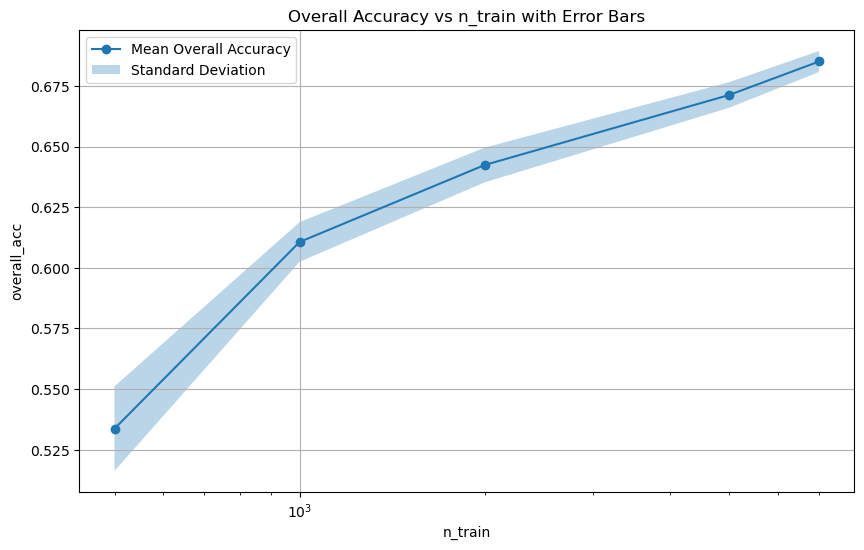

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataframe.
df_has_F_vanilla_scaling = pd.read_csv('tmp/has_F-vanilla-scaling_multi.csv')

# Print some info.
print(df_has_F_vanilla_scaling.head())
print(df_has_F_vanilla_scaling.info())

# Group by n_train and calculate mean and std for overall_acc
grouped = df_has_F_vanilla_scaling.groupby('n_train')['overall_acc'].agg(['mean', 'std']).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped['n_train'], grouped['mean'], label='Mean Overall Accuracy', marker='o')
plt.fill_between(grouped['n_train'], 
                 grouped['mean'] - grouped['std'], 
                 grouped['mean'] + grouped['std'], 
                 alpha=0.3, label='Standard Deviation')

plt.xlabel('n_train')
plt.ylabel('overall_acc')
plt.xscale('log')
plt.title('Overall Accuracy vs n_train with Error Bars')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('tmp/overall_acc-multi.png')

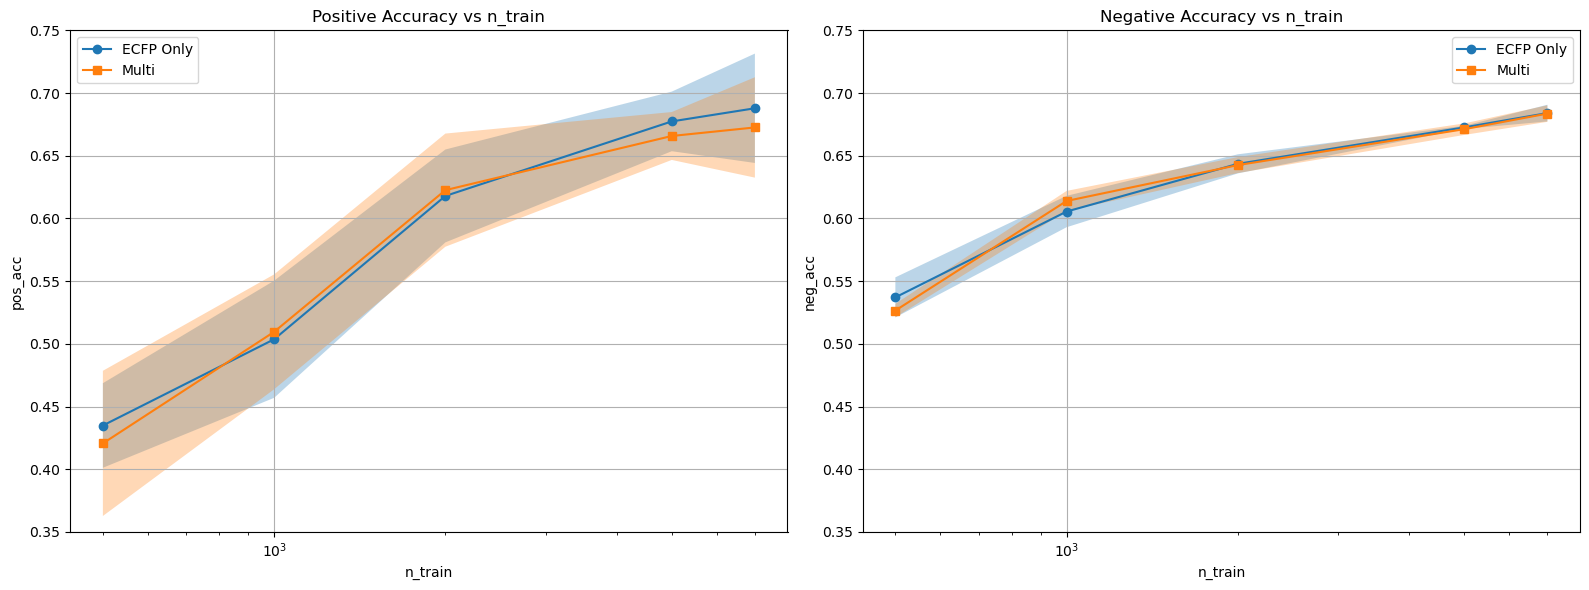

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframes
df_ecfp = pd.read_csv('tmp/has_F-vanilla-scaling_ecfponly.csv')
df_multi = pd.read_csv('tmp/has_F-vanilla-scaling_ecfp+bert+flag.csv')

# Aggregation function
def aggregate_data(df, metric):
    return df.groupby('n_train')[metric].agg(['mean', 'std']).reset_index()

# Prepare data for pos_acc
ecfp_pos = aggregate_data(df_ecfp, 'pos_acc')
multi_pos = aggregate_data(df_multi, 'pos_acc')

# Prepare data for neg_acc
ecfp_neg = aggregate_data(df_ecfp, 'neg_acc')
multi_neg = aggregate_data(df_multi, 'neg_acc')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pos_acc
ax = axes[0]
ax.plot(ecfp_pos['n_train'], ecfp_pos['mean'], label='ECFP Only', marker='o')
ax.fill_between(ecfp_pos['n_train'], 
                ecfp_pos['mean'] - ecfp_pos['std'], 
                ecfp_pos['mean'] + ecfp_pos['std'], 
                alpha=0.3)

ax.plot(multi_pos['n_train'], multi_pos['mean'], label='Multi', marker='s')
ax.fill_between(multi_pos['n_train'], 
                multi_pos['mean'] - multi_pos['std'], 
                multi_pos['mean'] + multi_pos['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('pos_acc')
ax.set_title('Positive Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.35, 0.75)
ax.set_xscale('log')

# Plot neg_acc
ax = axes[1]
ax.plot(ecfp_neg['n_train'], ecfp_neg['mean'], label='ECFP Only', marker='o')
ax.fill_between(ecfp_neg['n_train'], 
                ecfp_neg['mean'] - ecfp_neg['std'], 
                ecfp_neg['mean'] + ecfp_neg['std'], 
                alpha=0.3)

ax.plot(multi_neg['n_train'], multi_neg['mean'], label='Multi', marker='s')
ax.fill_between(multi_neg['n_train'], 
                multi_neg['mean'] - multi_neg['std'], 
                multi_neg['mean'] + multi_neg['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('neg_acc')
ax.set_title('Negative Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.35, 0.75)
ax.set_xscale('log')

plt.tight_layout()
# plt.savefig('pos_neg_acc_comparison.png')

# Save aggregated data
# Combine all into one structured format for CSV
ecfp_pos['metric'] = 'pos_acc'
ecfp_pos['type'] = 'ECFP Only'
multi_pos['metric'] = 'pos_acc'
multi_pos['type'] = 'Multi'

ecfp_neg['metric'] = 'neg_acc'
ecfp_neg['type'] = 'ECFP Only'
multi_neg['metric'] = 'neg_acc'
multi_neg['type'] = 'Multi'

df_agg_all = pd.concat([ecfp_pos, multi_pos, ecfp_neg, multi_neg], ignore_index=True)
df_agg_all.to_csv('aggregated_pos_neg_comparison.csv', index=False)